In [18]:
import numpy as np


In [19]:
# 前向sigmoid
def sigmod(z):
    h = 1. / (1 + np.exp(-z))
    return h


In [20]:
# 反向sigmoid，求导的结果
def de_sigmoid(z, h):
    return h * (1 - h)


In [21]:
# 前向relu
def relu(z):
    h = np.maximum(z, 0)
    return h


In [22]:
# 反向relu
def de_relu(z, h):
    z[z <= 0] = 0
    z[z > 0] = 1.0
    return z


In [23]:
# 前向无操作
def no_active(z):
    h = z
    return h


In [24]:
# 反向无操作
def de_no_active(z, h):
    return np.ones(h.shape)


In [25]:
# o Nxc
# lab Nxc
# 前向均方误差
def loss_L2(o, lab):
    diff = lab - o
    sqrDiff = diff ** 2
    return 0.5 * np.sum(sqrDiff)


In [26]:
# 反向均方误差
def de_loss_L2(o, lab):
    return o - lab


In [27]:
# 前向softmax交叉熵
def loss_CE(o, lab):
    p = np.exp(o) / np.sum(np.exp(o), axis=1, keepdims=True)
    loss_ce = np.sum(-lab * np.log(p))
    return loss_ce


In [28]:
# 反向softmax交叉熵
def de_loss_CE(o, lab):
    p = np.exp(o) / np.sum(np.exp(o), axis=1, keepdims=True)
    return p - lab


dim_in:输入特征的维度  
list_num_hidden： 每层输出节点的数目  
list_act_funs： 每层的激活函数  
list_de_act_funs: 反向传播时的函数  

In [29]:
def bulid_net(dim_in, list_num_hidden, list_act_funs, list_de_act_funs):

    layers = []

    # 逐层的进行网络构建
    for i in range(len(list_num_hidden)):
        layer = {}

        # 定义每一层的权重
        if i == 0:
            # 用sigmoid激活函数
            layer["w"] = 0.2*np.random.randn(dim_in, list_num_hidden[i])-0.1
            # layer["w"] = 0.01 * np.random.randn(dim_in, list_num_hidden[i])  # 用relu 激活函数
        else:
            # 用sigmoid激活函数
            layer["w"] = 0.2 * \
                np.random.randn(list_num_hidden[i-1], list_num_hidden[i])-0.1
            # layer["w"] = 0.01 * np.random.randn(list_num_hidden[i - 1], list_num_hidden[i])  # 用relu 激活函数

        # 定义每一层的偏置
        layer["b"] = 0.1 * np.ones([1, list_num_hidden[i]])
        layer["act_fun"] = list_act_funs[i]
        layer["de_act_fun"] = list_de_act_funs[i]
        layers.append(layer)

    return layers


In [30]:
def fead_forward(datas, layers):
    input_layers = []
    input_acfun = []
    for i in range(len(layers)):
        layer = layers[i]
        if i == 0:
            inputs = datas
            z = np.dot(inputs, layer["w"]) + layer["b"]
            h = layer['act_fun'](z)
            input_layers.append(inputs)
            input_acfun.append(z)
        else:
            inputs = h
            z = np.dot(inputs, layer["w"]) + layer["b"]
            h = layer['act_fun'](z)
            input_layers.append(inputs)
            input_acfun.append(z)
    return input_layers, input_acfun, h


In [35]:
# 进行参数更新更新
def updata_wb(datas, labs, layers, loss_fun, de_loss_fun, alpha=0.01):
    N, D = np.shape(datas)
    # 进行前馈操作
    inputs, input_acfun, output = fead_forward(datas, layers)
    # 计算 loss
    loss = loss_fun(output, labs)
    # 从后向前计算
    deltas0 = de_loss_fun(output, labs)
    # 从后向前计算误差
    deltas = []
    for i in range(len(layers)):
        index = -i - 1
        if i == 0:
            h = output
            z = input_acfun[index]
            delta = deltas0 * layers[index]["de_act_fun"](z, h)
        else:
            h = inputs[index + 1]
            z = input_acfun[index]
            # print(layers[index]["de_act_fun"](z,h)[1])
            delta = np.dot(delta, layers[index + 1]["w"].T) * \
                layers[index]["de_act_fun"](z, h)

        deltas.insert(0, delta)

    # 利用误差 对每一层的权重进行修成
    for i in range(len(layers)):
        # 计算 dw 与 db
        dw = np.dot(inputs[i].T, deltas[i])
        db = np.sum(deltas[i], axis=0, keepdims=True)
        # 梯度下降
        layers[i]["w"] = layers[i]["w"] - alpha * dw
        layers[i]["b"] = layers[i]["b"] - alpha * db

    return layers, loss


In [32]:
def test_accuracy(datas, labs_true, layers):
    _, _, output = fead_forward(datas, layers)
    lab_det = np.argmax(output, axis=1)
    labs_true = np.argmax(labs_true, axis=1)
    N_error = np.where(np.abs(labs_true - lab_det) > 0)[0].shape[0]

    error_rate = N_error / np.shape(datas)[0]
    return error_rate


In [33]:
def load_dataset_iris(file_data, N_train):
    # 数据读取
    datas = np.loadtxt(file_data, dtype=np.float64,
                       delimiter=',', usecols=(0, 1, 2, 3))
    labs = np.loadtxt(file_data, dtype=str, delimiter=',', usecols=(4))
    N, D = np.shape(datas)
    N_test = N - N_train
    unqiue_labs = np.unique(labs).tolist()

    dic_str2index = {}
    dic_index2str = {}
    for i in range(len(unqiue_labs)):
        lab_str = unqiue_labs[i]
        dic_str2index[lab_str] = i
        dic_index2str[i] = lab_str

    labs_onehot = np.zeros([N, len(unqiue_labs)])
    for i in range(N):
        labs_onehot[i, dic_str2index[labs[i]]] = 1

    perm = np.random.permutation(N)
    index_train = perm[:N_train]
    index_test = perm[N_train:]

    data_train = datas[index_train, :]
    lab_train_onehot = labs_onehot[index_train, :]

    data_test = datas[index_test, :]
    lab_test_onehot = labs_onehot[index_test]

    return data_train, lab_train_onehot, data_test, lab_test_onehot, dic_index2str


Visualization of data distribution

In [56]:

file_data = '/Users/precious/Desktop/Machine Learning/Neural Network(easy)/data/train-images.idx3-ubyte'

data_train, lab_train_onehot, data_test, lab_test_onehot, dic_index2str = load_dataset_iris(
    file_data, 100)


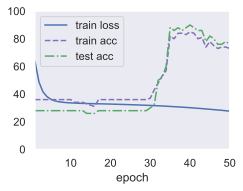

In [114]:
from d2l.torch import Animator
from torch import softmax

N, dim_in = np.shape(data_train)
# 定义网络结构
list_num_hidden = [10, 20, 3]
list_act_funs = [relu, relu, no_active]
list_de_act_funs = [de_relu, de_relu, de_no_active]
# list_act_funs = [sigmod, sigmod, sigmod]
# list_de_act_funs = [de_sigmoid, de_sigmoid, de_sigmoid]
# 定义损失函数
loss_fun = loss_L2
de_loss_fun = de_loss_L2

# loss_fun = loss_L2
# de_loss_fun=de_loss_L2

layers = bulid_net(dim_in, list_num_hidden,
                   list_act_funs, list_de_act_funs)


# 进行训练
n_epoch = 50
batchsize = 4
N_batch = N // batchsize

animator = Animator(xlabel='epoch', xlim=[1, n_epoch], ylim=[0,100],
                        legend=['train loss', 'train acc', 'test acc'])
for i in range(n_epoch):
    # 数据打乱
    rand_index = np.random.permutation(N).tolist()
    # 每个batch 更新一下weight
    loss_sum = 0
    for j in range(N_batch):
        index = rand_index[j * batchsize:(j + 1) * batchsize]
        batch_datas = data_train[index]
        batch_labs = lab_train_onehot[index]
        layers, loss = updata_wb(
            batch_datas, batch_labs, layers, loss_fun, de_loss_fun, alpha=0.001)
        loss_sum = loss_sum + loss
    
    # error = test_accuracy(data_train, lab_train_onehot, layers)
    # print("epoch %d  error  %.2f%%  loss_all %.2f" %
    #           (i, error * 100, loss_sum))
    # print(metric[0], 1 - test_accuracy(data_train, lab_train_onehot, layers))

    train_metrics = loss_sum, (1 - \
        test_accuracy(data_train, lab_train_onehot, layers)) * 100
    test_acc = (1 - test_accuracy(data_test, lab_test_onehot, layers)) * 100

    animator.add(i + 1, train_metrics + (test_acc,))

train_loss, train_acc = train_metrics
# assert train_loss < 0.5, train_loss
# assert train_acc <= 1 and train_acc > 0.7, train_acc
# assert test_acc <= 1 and test_acc > 0.7, test_acc

In [111]:
# 进行测试
error = test_accuracy(data_test, lab_test_onehot, layers)
print(error * 100)


26.0
